In [9]:
# Code written myself (Zygmunt Łenyk) with exceptions to:
# shuffle 2 matrices with the same permutation:
# http://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
# rotation and scaling images taken from Piotr Micek website
# 
# dodać wizualizacje filtrow po pierwszej warstwie
%load_ext line_profiler
from PIL import Image
import matplotlib.cm as cm
def unpickle(file):
    import sys
    import _pickle as cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='bytes')
    fo.close()
    return dict

# e.g 2 -> [0, 0, 1, ...]
def format_labels(labels):
    np.arange(len(labels))
    ret_labels = np.zeros((len(labels), 10))
    ret_labels[np.arange(len(labels)), labels] = 1
    return ret_labels

def rotate_reshaped_images(images):
    flat = images.reshape([-1, np.prod(images.shape[1:])])
    batch_images = np.apply_along_axis(utils.scale_and_rotate_image, 1, flat, images.shape[1:])
    return batch_images.reshape(images.shape)

def result_labels(probs):
    labels = np.zeros_like(probs)
    labels[np.arange(len(probs)), np.argmax(probs, axis=1)] = 1
    return labels

def _convert_images(raw):
    raw_float = np.array(raw, dtype=float) / 255.0
    images = raw_float.reshape([-1, 3, 32, 32])
    #images = images.transpose([0, 2, 3, 1])
    return images

def get_cifar_data(filename):
    dict = unpickle(filename)
    return (_convert_images(dict[b'data']), format_labels(dict[b'labels']))

def get_labels():
    labels = unpickle('../data/cifar-10-batches-py/batches.meta')
    print(labels[b'label_names'])
    names = []
    for label in labels[b'label_names']:
        names.append(label.decode('UTF-8'))
    return names

def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

def normalize_batch(images):
    images = (images - np.mean(images,axis=(0,2,3),keepdims=True)) / np.sqrt(np.var(images,axis=(0,2,3),keepdims=True) + 0.000001)

def softmax(y):
    return y - logsumexp(y, axis=1, keepdims=True)

def apply_dropout(y, dropout=0):
    return np.where(np.random.rand(*y.shape) < dropout, 0, y) / (1-dropout)

def apply_relu(x):
    return np.maximum(x, 0)

In [10]:
from sklearn import metrics
from autograd import grad
import autograd.numpy as np
from autograd.scipy.misc import logsumexp
from matplotlib import pyplot as plt
import random
import progressbar
from time import process_time

import autograd.scipy.signal
convolve = autograd.scipy.signal.convolve

import sys
sys.path.insert(0, '../utils')
import utils

labels_count = 10
batch_size = 32
init_scale = 0.05
num_of_epochs = 20

CONV = 'conv'
FC = 'fully_connected'
RELU = 'relu'
POOL = 'pool'


def count_shape(image_shape, filter_shape, padding=0):
    return [filter_shape[1], image_shape[1]-filter_shape[2]+1+2*padding, image_shape[2]-filter_shape[3]+1+2*padding]

def apply_conv(x, shape, W):
    x = apply_dropout(x, dropout=0.1)
    kernel, variance, bias = W[:-2*shape[1]], W[-2*shape[1]:-shape[1]], W[-shape[1]:]
    kernel = np.reshape(kernel, shape)
    conv = convolve(x, kernel, axes=([2, 3], [2, 3]), dot_axes=([1], [0]), mode='valid')
    normalize_batch(conv)
    conv = np.add(np.multiply((1+variance[:,np.newaxis,np.newaxis]),conv), bias[:,np.newaxis,np.newaxis])
    conv = apply_relu(conv)
    return conv
 
# x.shape = [dim,count,n,m] 
def apply_pooling(x, pool_size):
    x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]//pool_size, pool_size, x.shape[3]//pool_size,pool_size))
    return np.max(x, axis=(3,5))

def split_weights(W, layers):
    ind = 0
    for layer in layers:
        if layer['name'] == CONV:
            yield W[ind:ind+np.prod(layer['shape'])+2*layer['shape'][1]]
            ind = ind+np.prod(layer['shape'])+2*layer['shape'][1]
        elif layer['name'] == FC:
            yield W[ind:]
        else:
            yield 0

def layers_iterator(W, layers):
    W = split_weights(W, layers)
    for layer in layers:
        if layer['name'] == CONV:
            yield (layer['name'], layer['shape'], next(W))
        elif layer['name'] == POOL:
            yield (layer['name'], layer['pool_size'], next(W))
        elif layer['name'] == FC:
            yield (layer['name'], layer['shape'], next(W))
        else:
            yield (layer['name'], next(W))

class Network:
    # layers = [{'name': 'layer_name', 'shape': [...]}
    def __init__(self, images_shape, layers, learning_rate):
        self.learning_rate = learning_rate
        self.layers = layers
        self.total_sizes = 0
        for l in layers:
            if l['name'] == CONV:
                # l['shape] = [count, h, w]
                # needed: [dim, count, h, w], dim is in images_shape[0]
                l['shape'].insert(0, images_shape[0])
                self.total_sizes = self.total_sizes + np.prod(l['shape']) + 2*l['shape'][1]
                images_shape = count_shape(images_shape, l['shape'])
            elif l['name'] == POOL:
                images_shape[1] = images_shape[1]//l['pool_size']
                images_shape[2] = images_shape[2]//l['pool_size']
            elif l['name'] == FC:
                l['shape'].insert(0, np.prod(images_shape))
                self.total_sizes = self.total_sizes + np.prod(l['shape'])
                self.total_sizes = self.total_sizes + l['shape'][-1]
        self.W = (np.random.rand(self.total_sizes) - 0.5)/10
        print("Total sizes: "+str(self.total_sizes))

    def eval_x(self, W, X):
        layers = layers_iterator(W, self.layers)
        layer_input = X
        while True:
            try:
                args = list(next(layers))
                if args[0] == CONV:
                    shape, W = args[1], args[2]
                    layer_input = apply_conv(layer_input, shape, W)
                elif args[0] == RELU:
                    layer_input = apply_relu(layer_input)
                elif args[0] == POOL:
                    pool_size = args[1]
                    layer_input = apply_pooling(layer_input, pool_size)
                elif args[0] == FC:
                    shape, W = args[1], args[2]
                    w, b = W[:-shape[-1]], W[-shape[-1]:], 
                    layer_input = np.reshape(layer_input, (layer_input.shape[0],shape[0]))
                    layer_input = np.add(np.dot(layer_input, w.reshape(shape)), b)
            except StopIteration:
                #print("End of training")
                return layer_input
    
    def cost(self, W, batch_images, batch_labels):
        y = self.eval_x(W, batch_images)
        return (-np.sum(softmax(y)*batch_labels) / batch_size)
    
    def predict(self, images):
        y = self.eval_x(self.W, images)
        p = softmax(y)
        return result_labels(y)
    
    def score(self, test_set):
        test_images, test_labels = test_set
        print(test_images.shape)
        predicted_labels = self.predict(test_images)
        return metrics.accuracy_score(test_labels, predicted_labels)
   
    def train(self, train_set, test_set, start_epoch=0):
        old_score = 0
        best_W = np.copy(self.W)
        train_images, train_labels = train_set
        normalize_batch(train_images)
        print("Before training: " + str(self.score(test_set)) + "  Learning rate: " + str(self.learning_rate))
        for i in range(num_of_epochs):
            current_epoch = i + start_epoch
            shuffle_in_unison(train_images, train_labels)
            bar = progressbar.ProgressBar(max_value=len(train_labels)//batch_size)
            for j in range(len(train_labels)//batch_size):
                batch_images = train_images[j*batch_size:(j+1)*batch_size]
                #batch_images = rotate_reshaped_images(batch_images)
                batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
                dw = grad(self.cost, 0)(self.W, batch_images, batch_labels)
                self.W = self.W - dw*self.learning_rate
                bar.update(j+1)
            acc = self.score(test_set)
            print("After epoch " + str(current_epoch+1) + " : " + str(acc) + "  "
                  "Learning rate: " + str(self.learning_rate) + "  ")
            if (acc - old_score) <= 0:
                self.learning_rate = self.learning_rate / 2
            else:
                best_W = np.copy(self.W)
            old_score = acc
            if self.learning_rate < 0.01:
                return
        self.W = best_W

In [29]:
# conv layers size = [dimension, count, height, width]
network = Network(
    images_shape = [3,32,32],
    layers=[
    {'name':CONV, 'shape':[8,3,3]},#30
    {'name':POOL, 'pool_size':2},#15
    {'name':CONV, 'shape':[16,4,4]},#12
    {'name':POOL, 'pool_size':2},#6
    {'name':CONV, 'shape':[16,3,3]},#4
    {'name':FC, 'shape':[10]}],
    learning_rate = 0.1
)

Total sizes: 7218


In [30]:
train_set = []
(train_images, train_labels) = get_cifar_data('../data/cifar-10-batches-py/data_batch_1')
for i in range(2,5):
    train_pref = '../data/cifar-10-batches-py/data_batch_'
    new_set = get_cifar_data(train_pref+str(i))
    (new_images,new_labels) = new_set
    train_images = np.concatenate((train_images, new_images))
    train_labels = np.concatenate((train_labels, new_labels))
valid_set = get_cifar_data('../data/cifar-10-batches-py/data_batch_5')
print(train_images.shape)
network.train((train_images, train_labels), valid_set)
test_set = get_cifar_data(test_pref)


(40000, 3, 32, 32)
(10000, 3, 32, 32)
Before training: 0.0997  Learning rate: 0.1


100% (1250 of 1250) |##########################################| Elapsed Time: 0:07:57 ETA:  0:00:00

(10000, 3, 32, 32)
After epoch 1 : 0.2583  Learning rate: 0.1  


100% (1250 of 1250) |##########################################| Elapsed Time: 0:07:49 ETA:  0:00:00

(10000, 3, 32, 32)
After epoch 2 : 0.4005  Learning rate: 0.1  


100% (1250 of 1250) |##########################################| Elapsed Time: 0:07:55 ETA:  0:00:00

(10000, 3, 32, 32)
After epoch 3 : 0.4304  Learning rate: 0.1  


100% (1250 of 1250) |##########################################| Elapsed Time: 0:07:53 ETA:  0:00:00

(10000, 3, 32, 32)
After epoch 4 : 0.4633  Learning rate: 0.1  


100% (1250 of 1250) |##########################################| Elapsed Time: 0:08:01 ETA:  0:00:00

(10000, 3, 32, 32)
After epoch 5 : 0.4975  Learning rate: 0.1  


100% (1250 of 1250) |##########################################| Elapsed Time: 0:08:00 ETA:  0:00:00

(10000, 3, 32, 32)
After epoch 6 : 0.4977  Learning rate: 0.1  


 66% (828 of 1250) |#############################               | Elapsed Time: 0:05:11 ETA: 0:02:51

KeyboardInterrupt: 

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


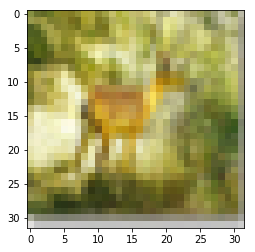

Predicted: frog
Actual: deer


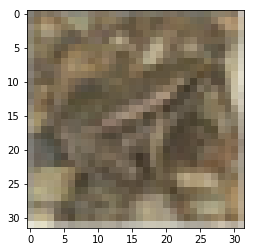

Predicted: deer
Actual: frog


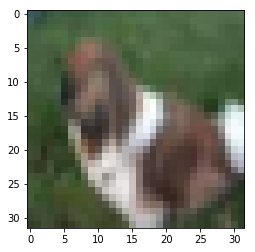

Predicted: bird
Actual: dog


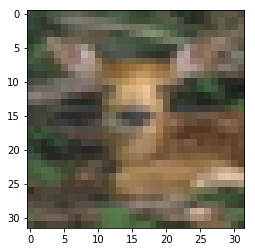

Predicted: deer
Actual: deer


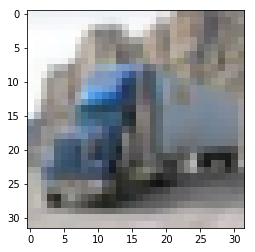

Predicted: automobile
Actual: truck


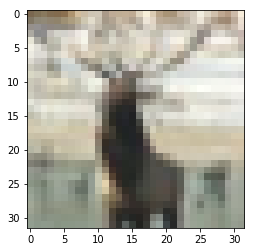

Predicted: deer
Actual: deer


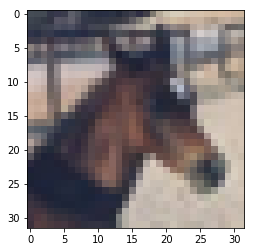

Predicted: cat
Actual: horse


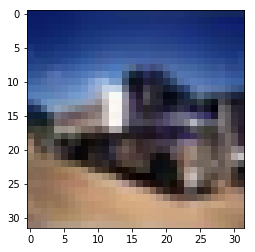

Predicted: airplane
Actual: truck


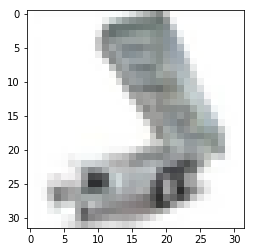

Predicted: cat
Actual: truck


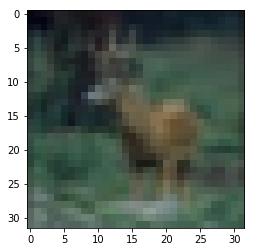

Predicted: deer
Actual: deer


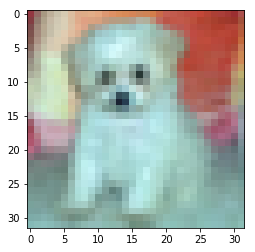

Predicted: dog
Actual: dog


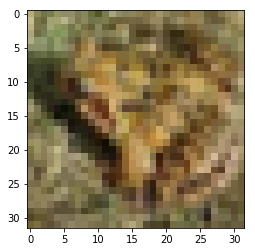

Predicted: frog
Actual: frog


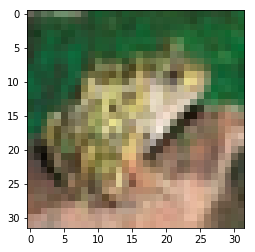

Predicted: frog
Actual: frog


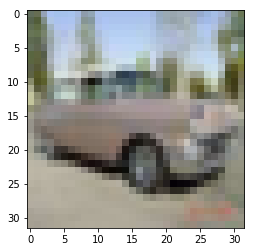

Predicted: automobile
Actual: automobile


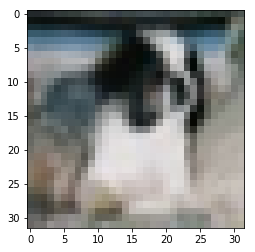

Predicted: dog
Actual: dog


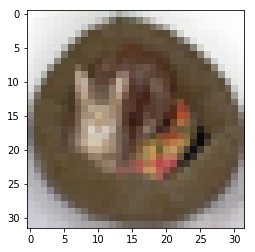

Predicted: cat
Actual: cat


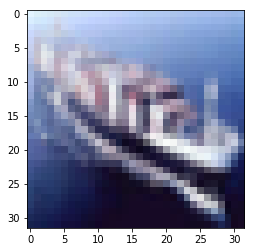

Predicted: ship
Actual: ship


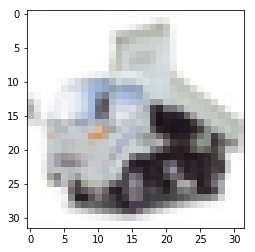

Predicted: automobile
Actual: truck


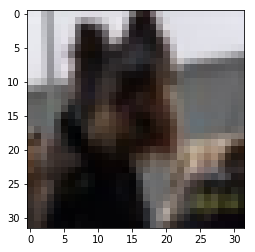

Predicted: cat
Actual: dog


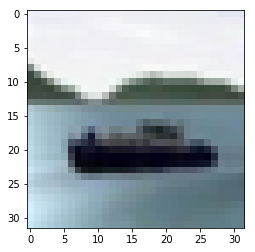

Predicted: ship
Actual: ship


In [32]:
names = get_labels()
print(names)
test_set = get_cifar_data('../data/cifar-10-batches-py/test_batch')
test_images, test_labels = test_set
test_images = test_images.reshape((test_images.shape[0],3,32,32))
predicted_labels = network.predict(test_images[500:1000])
#print("Score on test set: " + str(network.score((test_images[:1000], test_labels[:1000]))))
for i in range(20):
    plt.imshow(np.transpose(test_images[500+i], (1, 2, 0)), interpolation='nearest')
    plt.show()
    print("Predicted: " + str(names[predicted_labels[i].tolist().index(1)]))
    print("Actual: " + str(names[test_labels[500+i].tolist().index(1)]))
    

#for i in range(10):
#    img = Image.fromarray(test_images[i], 'RGB')
#    img.show()


In [3]:
train_set, valid_set, test_set = utils.import_data()
train_images, train_labels = train_set
#rotated_images = np.apply_along_axis(utils.scale_and_rotate_image, 1, train_images)
#train_images = np.concatenate((train_images, rotated_images))
#train_labels = np.concatenate((train_labels, train_labels))

valid_images, valid_labels = valid_set
valid_images = valid_images.reshape((valid_images.shape[0],1,28,28))

train_images = train_images.reshape((train_images.shape[0],1,28,28))
# conv layers size = [dimension, count, height, width]
network = Network(
    images_shape = [1,28,28],
    layers=[
    {'name':CONV, 'shape':[8,3,3]},#26
    {'name':POOL, 'pool_size':2}, #13
    {'name':CONV, 'shape':[8,4,4]}, #10
    {'name':POOL, 'pool_size':2}, #5
    {'name':CONV, 'shape':[16,4,4]}, #10
    {'name':FC, 'shape':[10]}],
    learning_rate = 0.1
)
# residual network

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz
Total sizes: 3858


In [4]:
%lprun -f apply_conv network.train((train_images, train_labels), (valid_images, valid_labels))


(5000, 1, 28, 28)
Before training: 0.1002  Learning rate: 0.1


100% (1718 of 1718) |#################################################################################################################################################| Elapsed Time: 0:04:38 ETA:  0:00:00

(5000, 1, 28, 28)
After epoch 1 : 0.9276  Learning rate: 0.1  


100% (1718 of 1718) |#################################################################################################################################################| Elapsed Time: 0:04:33 ETA:  0:00:00

(5000, 1, 28, 28)
After epoch 2 : 0.9558  Learning rate: 0.1  


100% (1718 of 1718) |##########################################| Elapsed Time: 0:04:39 ETA:  0:00:00

(5000, 1, 28, 28)
After epoch 3 : 0.9626  Learning rate: 0.1  


100% (1718 of 1718) |##########################################| Elapsed Time: 0:04:36 ETA:  0:00:00

(5000, 1, 28, 28)
After epoch 4 : 0.9674  Learning rate: 0.1  


100% (1718 of 1718) |##########################################| Elapsed Time: 0:04:36 ETA:  0:00:00

(5000, 1, 28, 28)
After epoch 5 : 0.971  Learning rate: 0.1  


100% (1718 of 1718) |##########################################| Elapsed Time: 0:04:30 ETA:  0:00:00

(5000, 1, 28, 28)
After epoch 6 : 0.973  Learning rate: 0.1  


 87% (1497 of 1718) |#####################################      | Elapsed Time: 0:04:00 ETA: 0:00:40

*** KeyboardInterrupt exception caught in code being profiled.

In [5]:
test_images, test_labels = test_set
test_images = test_images.reshape((test_images.shape[0],1,28,28))
print("Score on test set: " + str(network.score((test_images, test_labels))))

(10000, 1, 28, 28)
Score on test set: 0.9753


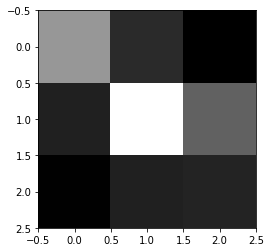

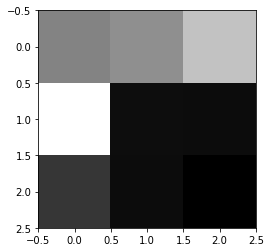

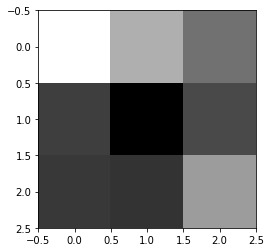

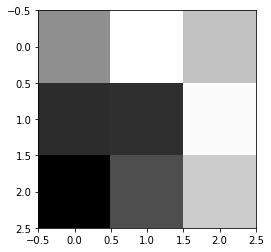

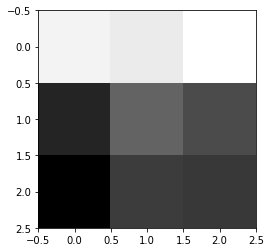

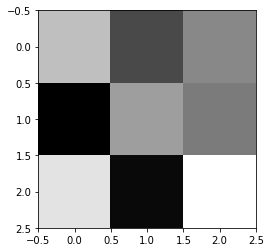

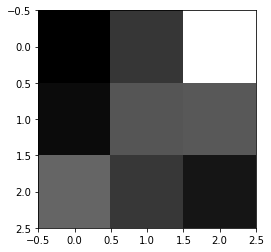

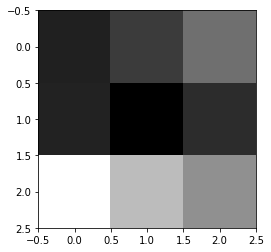

In [17]:
layers = layers_iterator(network.W, network.layers)
args = list(next(layers))
shape, W = args[1], args[2]
kernel, variance, bias = W[:-2*shape[1]], W[-2*shape[1]:-shape[1]], W[-shape[1]:]
kernel = np.reshape(kernel, shape[1:])
for i in range(len(kernel)):
    plt.imshow(kernel[i].reshape(3,3), interpolation='nearest', cmap='gray')
    plt.show()


In [26]:
# x.shape = [dim,count,n,m] 
import tensorflow as tf
import numpy as np
a = np.random.rand(1200).reshape(4,10,10,3)
kernel = np.random.rand(300).reshape(5,5,3,4)
conv = tf.nn.conv2d(a, kernel, strides=[1, 1, 1, 1], padding='SAME')
print(conv)
(test_images, test_labels) = get_cifar_data('../data/cifar-10-batches-py/test_batch')
im = test_images[0]
print(im.shape)
for i in range(3):
    print(im[i])
print(test_images.shape)
test_images = np.transpose(test_images, (0,2,3,1))
print(test_images.shape)
im = test_images[0]
print(im.shape)
for i in range(3):
    print(im[i])



Tensor("Conv2D_21:0", shape=(4, 10, 10, 4), dtype=float64)
(3, 32, 32)
[[ 0.61960784  0.62352941  0.64705882 ...,  0.5372549   0.49411765
   0.45490196]
 [ 0.59607843  0.59215686  0.62352941 ...,  0.53333333  0.49019608
   0.46666667]
 [ 0.59215686  0.59215686  0.61960784 ...,  0.54509804  0.50980392
   0.47058824]
 ..., 
 [ 0.26666667  0.16470588  0.12156863 ...,  0.14901961  0.05098039
   0.15686275]
 [ 0.23921569  0.19215686  0.1372549  ...,  0.10196078  0.11372549
   0.07843137]
 [ 0.21176471  0.21960784  0.17647059 ...,  0.09411765  0.13333333
   0.08235294]]
[[ 0.43921569  0.43529412  0.45490196 ...,  0.37254902  0.35686275
   0.33333333]
 [ 0.43921569  0.43137255  0.44705882 ...,  0.37254902  0.35686275
   0.34509804]
 [ 0.43137255  0.42745098  0.43529412 ...,  0.38431373  0.37254902
   0.34901961]
 ..., 
 [ 0.48627451  0.39215686  0.34509804 ...,  0.38039216  0.25098039
   0.33333333]
 [ 0.45490196  0.4         0.33333333 ...,  0.32156863  0.32156863
   0.25098039]
 [ 0.4196078